In [31]:
import pandas as pd
import numpy as np

from scipy import stats
from collections import defaultdict
from sklearn import preprocessing

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [33]:
cdf = pd.read_json('data/headline-graph-ava.json', lines=True)

In [34]:
cdf.head(10)

,d1,d2,kt_corr,misc_count,pr_corr,sp_corr
0,breitbart.com,thehill.com,0.375238,1258,0.000105,0.526036
1,breitbart.com,foxnews.com,0.411613,614,0.082881,0.574753
2,breitbart.com,msnbc.com,0.163371,719,-0.110645,0.243843
3,breitbart.com,dailycaller.com,0.512318,727,0.220853,0.697113
4,breitbart.com,wsj.com,-0.028693,307,-0.138920,-0.030124
5,breitbart.com,dailykos.com,0.206616,613,-0.067808,0.301632
6,breitbart.com,huffingtonpost.com,0.095080,395,-0.093701,0.143586
7,breitbart.com,apnews.com,0.057444,551,-0.096679,0.087256
8,breitbart.com,npr.org,0.058225,227,-0.119748,0.095242
9,breitbart.com,nytimes.com,-0.065126,201,-0.168998,-0.077272


In [35]:
adf = pd.read_json('thesis2/data/audience-graph.json', lines=True)

In [36]:
adf.head(10)

,d1,d2,kt_corr,kt_p,kt_scaled,pair,pr_corr,pr_p,pr_scaled,sp_corr,sp_p,sp_scaled
0,apnews.com,huffingtonpost.com,0.409975,0,1.158159,apnews.com - huffingtonpost.com,0.608099,0,1.118564,0.414992,0,1.137534
1,cnn.com,huffingtonpost.com,0.381343,0,0.937909,cnn.com - huffingtonpost.com,0.605665,0,1.106941,0.393144,0,0.972671
2,huffingtonpost.com,nytimes.com,0.377173,0,0.905824,huffingtonpost.com - nytimes.com,0.606705,0,1.111907,0.388864,0,0.940375
3,breitbart.com,huffingtonpost.com,0.082440,0,-1.361463,breitbart.com - huffingtonpost.com,0.099755,0,-1.308843,0.083766,0,-1.361842
4,huffingtonpost.com,msnbc.com,0.388553,0,0.993371,huffingtonpost.com - msnbc.com,0.603513,0,1.096665,0.392492,0,0.967752
5,huffingtonpost.com,sputniknews.com,0.073548,0,-1.429861,huffingtonpost.com - sputniknews.com,0.079595,0,-1.405112,0.074284,0,-1.433390
6,huffingtonpost.com,thehill.com,0.430191,0,1.313675,huffingtonpost.com - thehill.com,0.653357,0,1.334677,0.439938,0,1.325767
7,foxnews.com,huffingtonpost.com,0.191942,0,-0.519096,foxnews.com - huffingtonpost.com,0.228112,0,-0.695925,0.195816,0,-0.516331
8,dailykos.com,huffingtonpost.com,0.374307,0,0.883783,dailykos.com - huffingtonpost.com,0.590016,0,1.032211,0.377952,0,0.858031
9,buzzfeed.com,huffingtonpost.com,0.356139,0,0.744023,buzzfeed.com - huffingtonpost.com,0.536192,0,0.775199,0.361146,0,0.731216


In [74]:
C_SCORES = defaultdict(dict)
for r in cdf.itertuples():
    C_SCORES[r.d1][r.d2] = r.misc_count
    C_SCORES[r.d2][r.d1] = r.misc_count

In [75]:
A_SCORES = defaultdict(dict)
for r in adf.itertuples():
    A_SCORES[r.d1][r.d2] = r.kt_corr
    A_SCORES[r.d2][r.d1] = r.kt_corr

In [76]:
DOMAINS = list(C_SCORES.keys())

In [77]:
rows = []
for d1 in DOMAINS:
    
    other_domains = [d2 for d2 in DOMAINS if d2 != d1]
    
    a_scores = preprocessing.scale([A_SCORES[d1][d2] for d2 in other_domains])
    c_scores = preprocessing.scale([C_SCORES[d1][d2] for d2 in other_domains])
    
    for d2, av, cv in zip(other_domains, a_scores, c_scores):
        rows.append((d1, d2, av, cv))

In [78]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'av', 'cv'))

In [79]:
stats.pearsonr(df.av, df.cv)

(0.3326484317059635, 8.098946261861973e-07)

In [80]:
stats.kendalltau(df.av, df.cv)

KendalltauResult(correlation=0.17043771543910521, pvalue=0.00023884541837029715)

In [81]:
stats.linregress(df.av, df.cv)

LinregressResult(slope=0.33264843170596353, intercept=2.8138205560793117e-18, rvalue=0.3326484317059635, pvalue=8.098946261861983e-07, stderr=0.06538881567811396)

In [82]:
df['cv_av_diff'] = df.cv - df.av
df['pair'] = df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

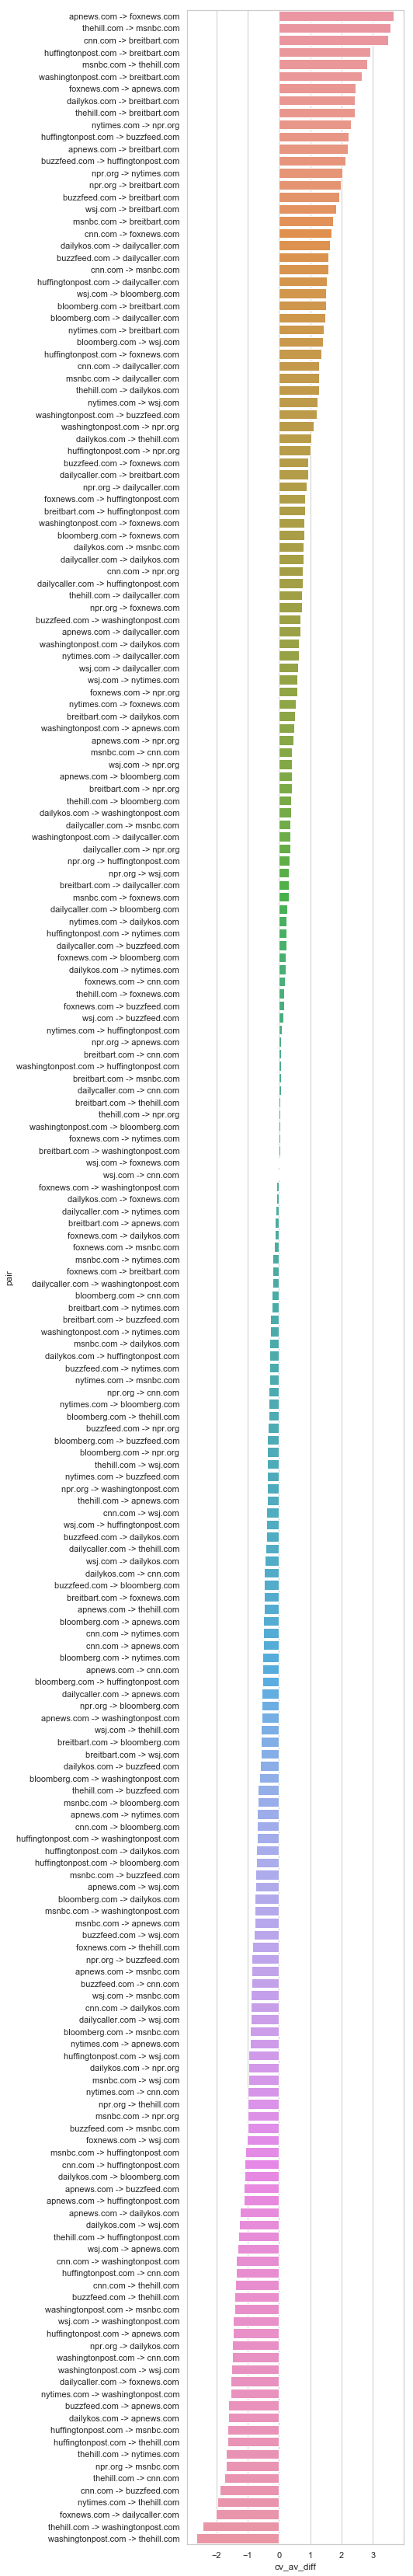

In [83]:
plt.figure(figsize=(5,60))
sns.barplot(y='pair', x='cv_av_diff', data=df.sort_values('cv_av_diff', ascending=False))

In [84]:
points = (alt
     .Chart(df)
     .mark_circle(size=50)
     .encode(x='av', y='cv', tooltip='pair'))

In [85]:
xfit = np.linspace(df.av.min(), df.av.max())
yfit = np.poly1d(np.polyfit(df.av, df.cv, 1))(xfit)
fit_df = pd.DataFrame(list(zip(xfit, yfit)), columns=('x', 'y'))

In [86]:
fit = (alt
    .Chart(fit_df, width=500, height=500)
    .mark_line()
    .encode(
        x=alt.X('x', scale=alt.Scale(domain=[-4, 4])),
        y=alt.Y('y', scale=alt.Scale(domain=[-4, 4])),
    ))

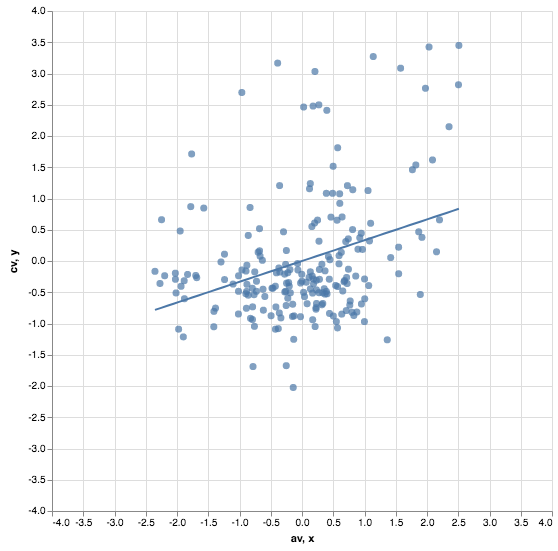

In [87]:
points + fit

In [88]:
def ac_corr(domain, plot=False):
    
    ddf = df[df.d1==domain]
    corr, p = stats.pearsonr(ddf.cv, ddf.av)
    
    if plot:
        
        pdf = ddf.melt('d2', ['cv', 'av'])
        order = ddf.sort_values('cv', ascending=False).d2
        
        print(d, corr, p)
        plt.figure(figsize=(3,5))
        sns.barplot(x='value', y='d2', hue='variable', data=pdf, order=order)
        plt.show()
    
    return corr, p

In [89]:
rows = []
for d in DOMAINS:
    corr, p = ac_corr(d)
    rows.append((d, corr, p))

In [90]:
gdf = pd.DataFrame(rows, columns=('domain', 'corr', 'p'))

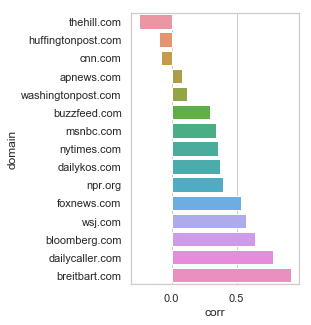

In [91]:
plt.figure(figsize=(3,5))
sns.barplot(x='corr', y='domain', data=gdf.sort_values('corr'))

thehill.com
thehill.com -0.25227002554539923 0.38424425814737917


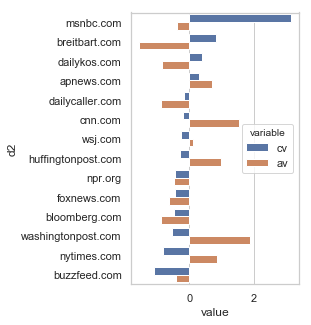

huffingtonpost.com
huffingtonpost.com -0.09396686517155628 0.7493327447664437


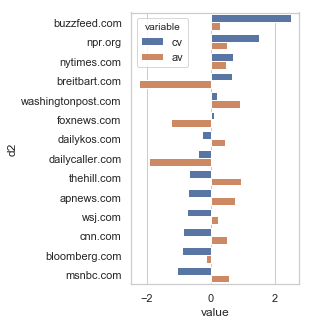

cnn.com
cnn.com -0.0780451922398636 0.7908583858588185


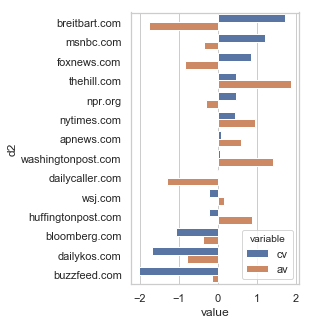

apnews.com
apnews.com 0.0789389762688067 0.7885125053803486


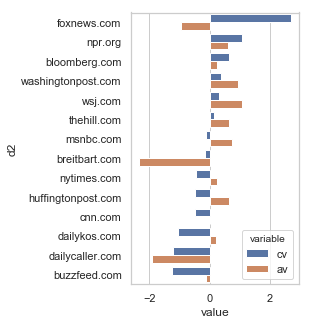

washingtonpost.com
washingtonpost.com 0.11827588491132093 0.6871644276349564


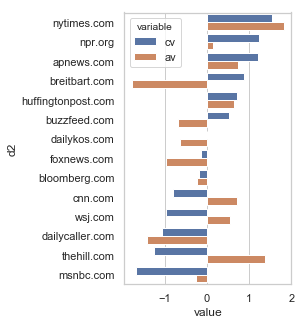

buzzfeed.com
buzzfeed.com 0.29831825314860494 0.30021625220865755


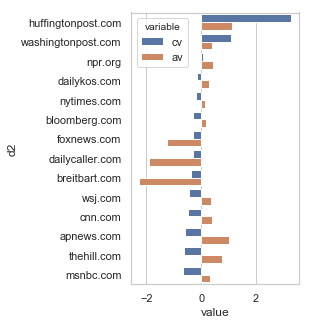

msnbc.com
msnbc.com 0.34256896302082057 0.23053645685931418


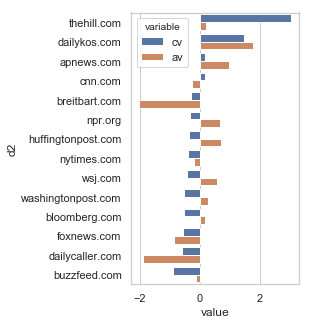

nytimes.com
nytimes.com 0.35521989021006056 0.21264004039870085


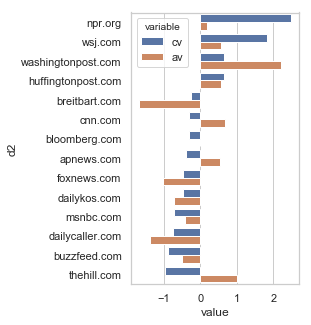

dailykos.com
dailykos.com 0.3731835986110518 0.18876775679993105


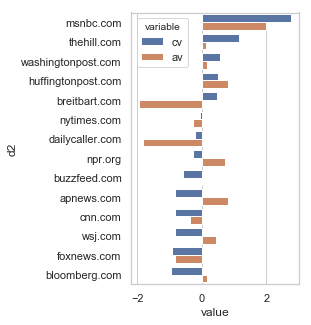

npr.org
npr.org 0.3989475130127083 0.1576441031646101


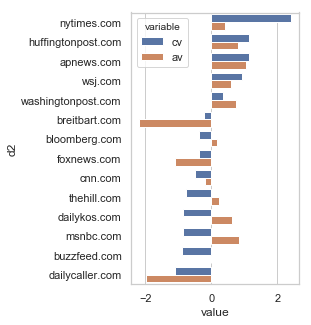

foxnews.com
foxnews.com 0.5372828262418307 0.047554659519080715


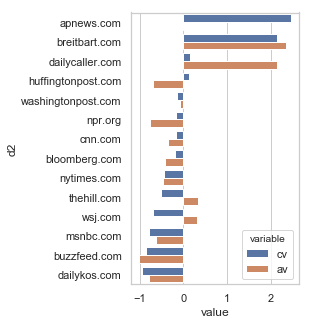

wsj.com
wsj.com 0.5739879725265069 0.031837918941536925


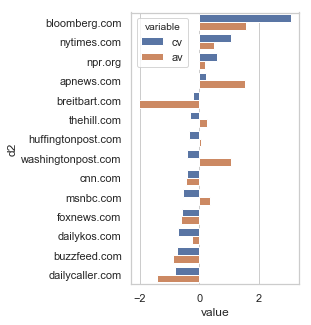

bloomberg.com
bloomberg.com 0.6390360172886859 0.01388223068822433


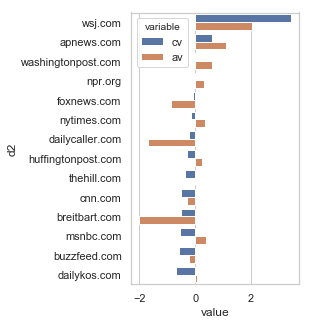

dailycaller.com
dailycaller.com 0.7795044284276366 0.0010123760218488974


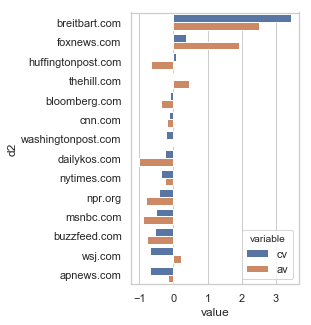

breitbart.com
breitbart.com 0.9187442348782378 3.4815165265852384e-06


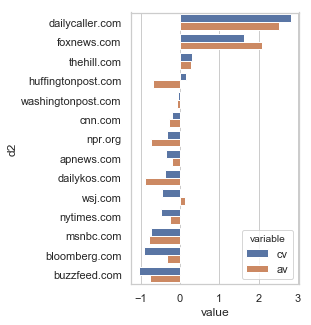

In [92]:
for d in gdf.sort_values('corr').domain:
    print(d)
    ac_corr(d, True)